In [1]:
# Importing packages

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

# For benchmark solution
import quantecon as qe
from quantecon import LQ

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [3]:
# Economic paramters
def get_parameters(beta=0.9,
                   alpha_0=1.0,
                   alpha_1=1.3,
                   gamma=90.0,
                   h_0=0.05,
                   h_1=0.9,
                   y_0=0.1,
                   Y_0=0.1):
 #h_0 and h_1 are set such that Y_bar = 1
    params = {
        'beta': beta,
        'alpha_0': alpha_0,
        'alpha_1': alpha_1,
        'gamma': gamma,
        'h_0': h_0,
        'h_1': h_1,
        'y_0': y_0,
        'Y_0': Y_0
    }

    return params

In [4]:
# Training data

def grid_D(params, grid_num_y, grid_num_Y, y_upper_bound, Y_upper_bound):
    y_0 = params["y_0"]
    Y_0 = params["Y_0"]
    grid_y = torch.linspace(y_0, y_upper_bound, steps = grid_num_y).unsqueeze(dim=1)
    grid_Y = torch.linspace(Y_0, Y_upper_bound, steps = grid_num_Y).unsqueeze(dim=1)
    grid_yY = torch.cartesian_prod(grid_y.squeeze(), grid_Y.squeeze())
    #creating the state for LQ, testing and policy error
    ones = torch.ones([len(grid_y)*len(grid_Y),1])
    state = torch.cat((ones,grid_yY), dim =1).T
    
    return grid_yY, grid_y, grid_Y

In [5]:
# Test data

In [6]:
def test_data(params, u_theta, time_period):
    y_0 = params["y_0"]
    Y_0 = params["Y_0"]

    y_hat_t = torch.zeros(time_period, 1)
    Y_t = torch.zeros(time_period, 1)

    h_0 = params["h_0"]
    h_1 = params["h_1"]

    y_hat_t[0] = y_0
    Y_t[0] = Y_0


    for t in range(1, time_period): # constructing Y_t
        Y_t[t] = h_0 + h_1 * Y_t[t-1]
    
    u_theta.eval() 

    with torch.no_grad(): # Constructing u_hat_t
        u_hat_t = u_theta(Y_t)

    for t in range(1, time_period): # Constructing y_t using u_hat_t
            y_hat_t[t] = y_hat_t[t-1] + u_hat_t[t-1]
        
    yY_t = torch.cat((y_hat_t,Y_t), dim = 1)
    return yY_t, y_hat_t, Y_t, u_hat_t

In [7]:
# Euler and Bellman Residuals
def euler_residual(params,u_theta,Y):
    α_0 = params["alpha_0"]
    α_1 = params["alpha_1"]
    β = params["beta"]
    h_0 = params["h_0"]
    h_1 = params["h_1"]
    γ = params["gamma"]
    Y_prime = h_0 + h_1 * Y
    P_prime = α_0 - α_1 * Y_prime
        
    lhs_euler = γ * u_theta(Y)
    rhs_euler = β * (P_prime + γ * u_theta(Y_prime))
    residual_euler = rhs_euler - lhs_euler
    return residual_euler

def bellman_residual(params,u_theta,v_theta,yY):
    α_0 = params["alpha_0"]
    α_1 = params["alpha_1"]
    β = params["beta"]
    h_0 = params["h_0"]
    h_1 = params["h_1"]
    γ = params["gamma"]
    
    y = yY[:,[0]]
    Y = yY[:,[1]]
    
    with torch.no_grad():
        u = u_theta(Y)
        
    y_prime = y + u
    Y_prime = h_0+ h_1*Y
    P = α_0 - (α_1*Y)
    yY_prime = torch.cat((y_prime,Y_prime), dim = 1)
    lhs_bellman = v_theta(yY)
    rhs_bellman = -(γ/2)*(u**2)+ (P*y) + β*v_theta(yY_prime)
    residual_bellman = rhs_bellman - lhs_bellman
    return residual_bellman   

In [8]:
# Neural net

In [9]:
class NN(nn.Module):
    def __init__(self,
                 input_dim = 1,
                 dim_hidden=128,
                 layers=2,
                 hidden_bias=True,
                 hidden_activation=nn.Tanh,
                 softplus_beta = 1.0,
                 positivity = False,
                 seed=123):
        super().__init__()
        self.input_dim = input_dim
        self.dim_hidden = dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        self.hidden_activation = hidden_activation
        self.softplus_beta = softplus_beta
        self.positivity = positivity
        self.seed = seed

        # Set seed if provided
        if self.seed is not None:
            torch.manual_seed(self.seed)
        
        module = []
        
        # First layer
        module.append(nn.Linear(self.input_dim, self.dim_hidden, bias=self.hidden_bias))
        module.append(self.hidden_activation())

        # Additional hidden layers
        for _ in range(self.layers - 1):
            module.append(nn.Linear(self.dim_hidden, self.dim_hidden, bias=self.hidden_bias))
            module.append(self.hidden_activation())

        # Output layer + Softplus (hard-coded)
        module.append(nn.Linear(self.dim_hidden, 1))
        if self.positivity:
            module.append(nn.Softplus(beta=softplus_beta))  # y >= 0

        self.q = nn.Sequential(*module)

    def forward(self, x):
        return self.q(x)

## Solving Euler Equation

In [10]:
# Econ params

In [11]:
param = get_parameters()

In [12]:
# Training data and data loader


In [13]:
yY_train, y_train, Y_train = grid_D(params=param, grid_num_y=12, grid_num_Y=12, y_upper_bound=1.2, Y_upper_bound=0.5)

data_loader_euler = DataLoader(torch.utils.data.TensorDataset(Y_train), batch_size=len(Y_train), shuffle=False)

In [14]:
# Initializing Neural Network

In [15]:
u_theta = NN(input_dim = 1, layers= 1, dim_hidden= 512, hidden_activation = nn.ReLU, seed = 1)

In [16]:
# Setting up the optimizer

In [17]:
num_epochs_euler = 3001
print_frequency = 1000

optimizer_euler = torch.optim.AdamW(u_theta.parameters(), lr=1e-3)
scheduler_euler = torch.optim.lr_scheduler.StepLR(optimizer_euler, step_size=100, gamma=0.95)

In [18]:
# Lists to store evolution
u_hat_evolution = []
epochs_recorded = []

for epoch in range(num_epochs_euler):
    for (Y,) in data_loader_euler:
        optimizer_euler.zero_grad()

        residual_euler = euler_residual(params=param, u_theta=u_theta, Y=Y)
        loss_euler = (residual_euler**2).mean()

        loss_euler.backward()
        optimizer_euler.step()
        
    scheduler_euler.step()

    # Test data for monitoring
    yY_t, y_hat_t, Y_t, u_hat_t = test_data(params=param, u_theta=u_theta, time_period=15)

    # Save u_hat_t and epoch every 3 epochs
    if epoch % 3 == 0:
        u_hat_evolution.append(u_hat_t.detach().cpu().clone())  # detach in case it's a tensor
        epochs_recorded.append(epoch)

    if epoch % print_frequency == 0:
        print(f"epoch = {epoch}, loss_Euler = {loss_euler.item():.2e}")

# At the end you can access:
# u_hat_evolution -> list of u_hat_t every 3 epochs
# epochs_recorded -> corresponding epoch numbers

epoch = 0, loss_Euler = 1.07e-01
epoch = 1000, loss_Euler = 6.84e-12
epoch = 2000, loss_Euler = 2.21e-11
epoch = 3000, loss_Euler = 1.77e-11


In [19]:
u_hat_array = np.stack([u.detach().cpu().numpy() for u in u_hat_evolution]).squeeze()
epochs_array = np.array(epochs_recorded)

In [20]:
# Testing

## Solving Bellman Equation

In [21]:
# Initializing neural network
v_theta = NN(input_dim = 2, layers= 2, dim_hidden= 256, hidden_activation = nn.ReLU, positivity = True , seed = 123)

In [22]:
data_loader_bellman= DataLoader(yY_train, batch_size=len(yY_train), shuffle= False)
num_epochs_bellman = 3001

In [23]:
learning_rate_bellman = 1e-3
optimizer_bellman = torch.optim.AdamW(v_theta.parameters(), lr=learning_rate_bellman)  
scheduler_bellman = torch.optim.lr_scheduler.StepLR(optimizer_bellman, step_size=100, gamma=0.99)

In [24]:
# Lists to store evolution
v_hat_evolution = []
epochs_bellman_recorded = []

for epoch in range(num_epochs_bellman):
    for data in data_loader_bellman:
        optimizer_bellman.zero_grad()  # Resetting the gradients

        residual_Bellman = bellman_residual(params=param, u_theta=u_theta, v_theta=v_theta, yY=data)
        loss_bellman = (residual_Bellman**2).mean()
            
        loss_bellman.backward()  # Calculating gradients
        optimizer_bellman.step()  # Update parameters

    scheduler_bellman.step()  # Update learning rate

    # Test data evaluation every 3 epochs
    if epoch % 3 == 0:
        # Assuming yY_t is already defined from test data
        v_hat_t = v_theta(yY_t)
        v_hat_evolution.append(v_hat_t.detach().cpu().clone())
        epochs_bellman_recorded.append(epoch)

    if epoch % print_frequency == 0:
        print(f"epoch = {epoch}, loss_Bellman = {loss_bellman.detach().cpu().item():.2e}")


epoch = 0, loss_Bellman = 1.01e-01
epoch = 1000, loss_Bellman = 8.57e-07
epoch = 2000, loss_Bellman = 2.38e-07
epoch = 3000, loss_Bellman = 1.03e-07


In [25]:

# Convert lists to NumPy arrays
v_hat_array = np.stack([v.detach().cpu().numpy() for v in v_hat_evolution]).squeeze()
epochs_bellman_array = np.array(epochs_bellman_recorded)

print("v_hat_array shape:", v_hat_array.shape)
print("epochs_bellman_array:", epochs_bellman_array)

v_hat_array shape: (1001, 15)
epochs_bellman_array: [   0    3    6 ... 2994 2997 3000]


In [26]:
## Test data

In [27]:
v_theta.eval()
with torch.no_grad():
    v_hat_t = v_theta(yY_t)

## Solution from an LQ Solver

In [28]:
def LQ_theory(y,Y, params, time_periods):
    # y : n by 1 tensor, is the state vector
    # Y :  n by 1 tensor, is the state vector
    β = params["beta"]
    α_0 = params["alpha_0"]
    α_1 = params["alpha_1"]
    γ = params["gamma"]
    h_0 = params["h_0"]
    h_1 = params["h_1"]
    y_0 = params["y_0"]
    Y_0 = params["Y_0"]
    
    R = np.matrix([[0.0,-α_0/2 , 0.0],[-α_0/2, 0.0, α_1/2],[0.0,α_1/2, 0.0]])
    Q = γ/2
    A = np.matrix([[1.0,0.0,0.0],[0.0,1.0,0.0],[h_0,0.0, h_1]])
    B = np.matrix([[0.0],[1.0],[0.0]])
    lq = LQ(Q, R, A, B, beta = β)
    P, F, d = lq.stationary_values()

    P_tens = torch.tensor(P, dtype=torch.float32)      # (n, n)
    F_tens = torch.tensor(F, dtype=torch.float32)      # (1, n)
    d_tens = torch.tensor(d, dtype=torch.float32)
    
    x_0 = np.matrix([[1.0],[y_0],[Y_0]])
    dynamics = lq.compute_sequence(x_0, time_periods-1)
        
    ones = dynamics[0][0].reshape([time_periods,1])
    y_t = dynamics[0][1].reshape([time_periods,1])
    Y_t = dynamics[0][2].reshape([time_periods,1])

    ones = np.ones([len(y_t),1])
    x_t = np.concatenate((ones, y_t, Y_t), axis=1).T
    u_t = (-F@x_t).T

    ones_tens = torch.ones([len(y), 1])
    x_tensor = torch.cat((ones_tens,y,Y), dim =1).T

    v_tens = -(x_tensor.T @ P_tens @ x_tensor)
    v_tens_result = torch.diag(v_tens).unsqueeze(dim =1)
    u_tens = (-F_tens@x_tensor).T # 3\times n
    return v_tens_result, y_t,Y_t, u_tens
    

In [29]:
v_t, _ , _ , u_t = LQ_theory(y = y_hat_t, Y = Y_t, params = param, time_periods = 15)


## Plotting the results

In [30]:
fontsize= 14
ticksize = 14
figsize = (10, 8)
params_fig = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_fig)

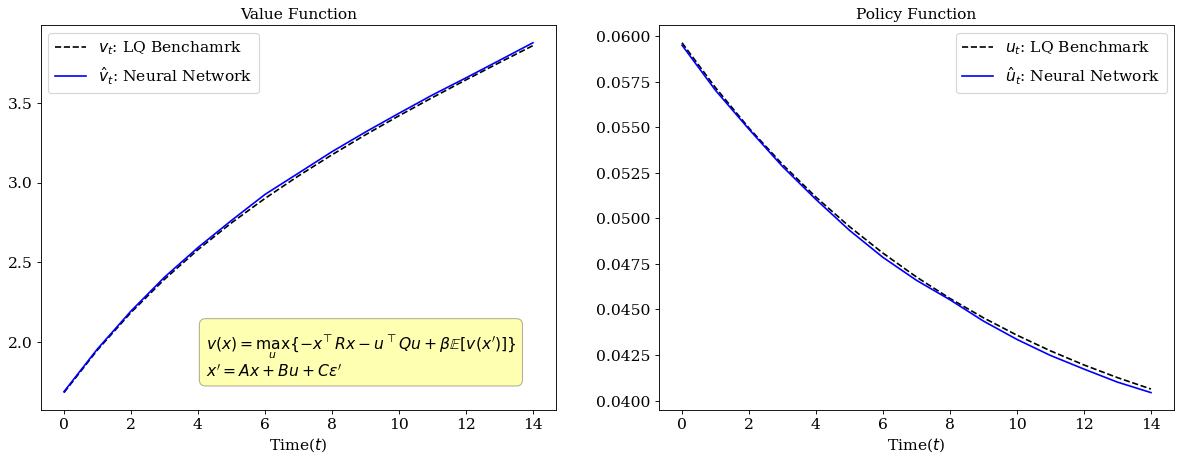

In [31]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: value functions
axes[0].plot(v_t, linestyle="--", color= "k" , label= r"$v_t$: LQ Benchamrk")
axes[0].plot(v_hat_t, color = "b", label=r"$\hat{v}_t$: Neural Network")
axes[0].set_title("Value Function")

axes[0].text(
    0.32, 0.2,
    r"$v(x) = \max_{u}\{ -x^\top R x - u^\top Q u + \beta \mathbb{E}[v(x')] \}$"
    "\n"
    r"$x' = A x + B u + C\epsilon'$",
    transform=axes[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round,pad=0.4",
        facecolor="yellow",
        edgecolor="black",
        alpha=0.3
    )
)

axes[0].set_xlabel("Time($t$)")
axes[0].legend()

# Right panel: policies
axes[1].plot(u_t, color = "k", linestyle = "--", label=r"$u_t$: LQ Benchmark")
axes[1].plot(u_hat_t, color = "b",  label=r"$\hat{u}_t$: Neural Network")
axes[1].set_xlabel("Time($t$)")
axes[1].set_title("Policy Function")
axes[1].legend()

plt.tight_layout()
plt.show()


In [32]:
img = mpimg.imread("christmas.png")

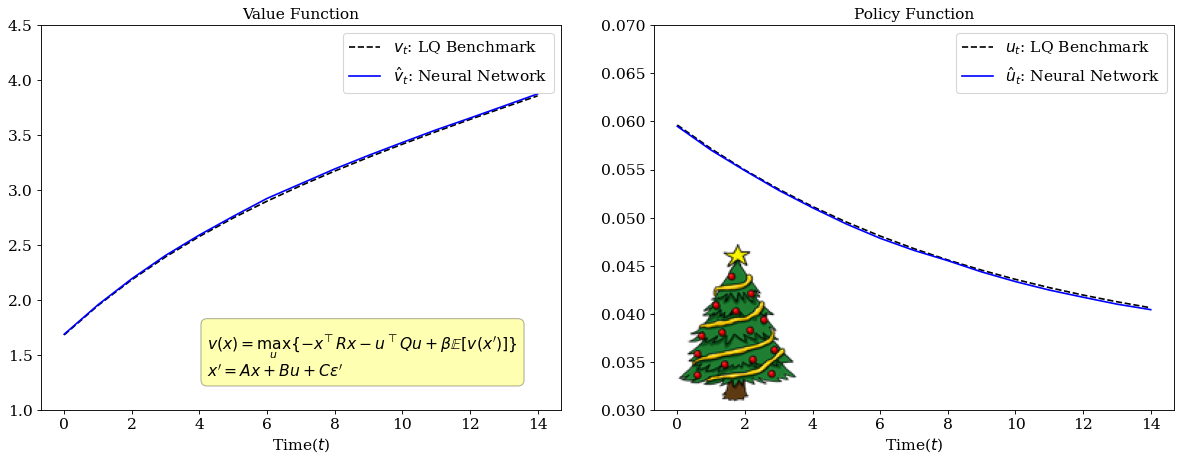

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left panel: value functions
axes[0].plot(v_t, linestyle="--", color="k", label=r"$v_t$: LQ Benchmark")
axes[0].plot(v_hat_t, color="b", label=r"$\hat{v}_t$: Neural Network")
axes[0].set_title("Value Function")

axes[0].text(
    0.32, 0.2,
    r"$v(x) = \max_{u}\{ -x^\top R x - u^\top Q u + \beta \mathbb{E}[v(x')] \}$"
    "\n"
    r"$x' = A x + B u + C\epsilon'$",
    transform=axes[0].transAxes,
    fontsize=14,
    verticalalignment="top",
    bbox=dict(
        boxstyle="round,pad=0.4",
        facecolor="yellow",
        edgecolor="black",
        alpha=0.3
    )
)

# Load image
axes[0].set_ylim(1.0, 4.5)   # e.g. (-0.5, 0.5)
axes[0].set_xlabel("Time($t$)")
axes[0].legend(loc = "upper right")

# Right panel: policies
axes[1].plot(u_t, color="k", linestyle="--", label=r"$u_t$: LQ Benchmark")
axes[1].plot(u_hat_t, color="b", label=r"$\hat{u}_t$: Neural Network")
imagebox = OffsetImage(img, zoom=1.3)  # adjust zoom to your liking
ab = AnnotationBbox(imagebox, (0.15, 0.22), frameon=False, xycoords='axes fraction')  # position in axes fraction
axes[1].add_artist(ab)
axes[1].set_ylim(0.03, 0.07)   # e.g. (-0.5, 0.5)
axes[1].set_xlabel("Time($t$)")
axes[1].set_title("Policy Function")
axes[1].legend(loc = "upper right")

plt.tight_layout()
plt.show()


In [34]:
# Making the animiation 

In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio  # use v2 API to avoid warning

In [36]:
max_v = v_hat_array.max()
min_v = v_hat_array.min()

max_u = u_hat_array.max()
min_u = u_hat_array.min()

In [37]:
max_u

0.1324952

In [38]:
num_frame = len(u_hat_array)
num_frame

1001

In [39]:
img = mpimg.imread("christmas.png")

In [40]:
filenames = []
#for i in range(epoch_outputs.shape[0]):
for i in range(150):
    v_hat_t = v_hat_array[i,:]
    u_hat_t = u_hat_array[i,:]
    epoch_i = epochs_array[i]   # <-- epoch number
    for t in range(20):
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))

        # Left panel: value functions
        axes[0].plot(v_t, linestyle="--", color="k", label=r"$v_t$: LQ Benchmark")
        axes[0].plot(v_hat_t, color="b", label=r"$\hat{v}_t$: Neural Network")
        axes[0].set_title("Value Function")

        axes[0].text(
        0.32, 0.2,
        r"$v(x) = \max_{u}\{ -x^\top R x - u^\top Q u + \beta \mathbb{E}[v(x')] \}$"
        "\n"
        r"$x' = A x + B u + C\epsilon'$",
        transform=axes[0].transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=dict(
        boxstyle="round,pad=0.4",
        facecolor="yellow",
        edgecolor="black",
        alpha=0.3
        )
            
        )
        axes[0].text(
            0.4, 0.3,
            f"Epoch = {epoch_i}",
            transform=axes[0].transAxes,
            fontsize=14,
            ha="center",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="pink",
                edgecolor="black",
                alpha=0.8
            )
        )

        axes[0].set_ylim(1.0, 4.5)   # e.g. (-0.5, 0.5)
        axes[0].set_xlabel("Time($t$)")
        axes[0].legend(loc = "upper right")

        # Right panel: policies
        axes[1].plot(u_t, color="k", linestyle="--", label=r"$u_t$: LQ Benchmark")
        axes[1].plot(u_hat_t, color="b", label=r"$\hat{u}_t$: Neural Network")
        imagebox = OffsetImage(img, zoom=1.3)  # adjust zoom to your liking
        ab = AnnotationBbox(imagebox, (0.15, 0.22), frameon=False, xycoords='axes fraction')  # position in axes fraction
        axes[1].add_artist(ab)
        axes[1].set_ylim(0.03, 0.07)   # e.g. (-0.5, 0.5)
        axes[1].set_xlabel("Time($t$)")
        axes[1].set_title("Policy Function")
        axes[1].legend(loc = "upper right")
    
        plt.tight_layout()
    
        # create file name and append it to a list
        filename = f'frame_{i:03d}_{t:02d}.png'
        filenames.append(filename)
        plt.savefig(filename)
        plt.close()# build gif
with imageio.get_writer('LQ.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)
    
   